In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [2]:

def count_files_in_directories(root_dir):
    dir_counts = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        dir_name = os.path.basename(dirpath)
        file_count = len(filenames)
        dir_counts.append((dir_name, file_count))
    
    return dir_counts

root_directory = '/kaggle/input/wikiart'

directory_counts = count_files_in_directories(root_directory)

style = pd.DataFrame(directory_counts, columns=['name', 'count'])
style = style[(style['count'] > 200) & (style['count'] < 1400)]
style = style.sort_values(by=['count'], ascending=False)
style = style.reset_index(drop=True)

style['class_weight'] = style['count'].sum() / (style.shape[0] * style['count'])

style_name = style['name'].values

print(style_name)

['Early_Renaissance' 'High_Renaissance' 'Minimalism'
 'Mannerism_Late_Renaissance' 'Ukiyo_e' 'Fauvism' 'Pointillism'
 'Contemporary_Realism' 'New_Realism' 'Synthetic_Cubism']


In [3]:

class_weights = style['class_weight'].to_dict()
class_weights

{0: 0.6452192667145938,
 1: 0.6682799702159344,
 2: 0.6712789827973074,
 3: 0.7017200938232995,
 4: 0.7690659811482433,
 5: 0.9609207708779444,
 6: 1.7495126705653021,
 7: 1.865904365904366,
 8: 2.8582802547770703,
 9: 4.155092592592593}

In [4]:
class_num = style.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory='/kaggle/input/wikiart',
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=style_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory='/kaggle/input/wikiart',
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=style_name.tolist()
                                                   )

train_step = train_generator.n//train_generator.batch_size
val_step = valid_generator.n//valid_generator.batch_size

Found 7185 images belonging to 10 classes.
Found 1790 images belonging to 10 classes.


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [6]:
X = base_model.output
X = Flatten()(X)

X = Dense(256, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(32, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)


output = Dense(class_num, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [7]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [9]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=train_step,
                              validation_data=valid_generator, validation_steps=val_step,
                              epochs=40,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=False,
                              workers=4,
                              class_weight=class_weights
                             )

Epoch 1/40
449/449 [==============================] - 226s 504ms/step - loss: 1.6061 - acc: 0.4769 - val_loss: 3.7651 - val_acc: 0.1486
Epoch 2/40
449/449 [==============================] - 205s 456ms/step - loss: 1.2508 - acc: 0.6015 - val_loss: 1.6205 - val_acc: 0.4336
Epoch 3/40
449/449 [==============================] - 205s 457ms/step - loss: 1.1060 - acc: 0.6398 - val_loss: 1.2809 - val_acc: 0.5619
Epoch 4/40
449/449 [==============================] - 208s 463ms/step - loss: 1.0063 - acc: 0.6655 - val_loss: 1.1879 - val_acc: 0.6053
Epoch 5/40
449/449 [==============================] - 206s 458ms/step - loss: 0.9609 - acc: 0.6776 - val_loss: 1.2701 - val_acc: 0.5912
Epoch 6/40
449/449 [==============================] - 207s 461ms/step - loss: 0.8854 - acc: 0.6965 - val_loss: 1.1658 - val_acc: 0.5935
Epoch 7/40
449/449 [==============================] - 208s 464ms/step - loss: 0.8773 - acc: 0.6981 - val_loss: 1.3310 - val_acc: 0.5563
Epoch 8/40
449/449 [============================

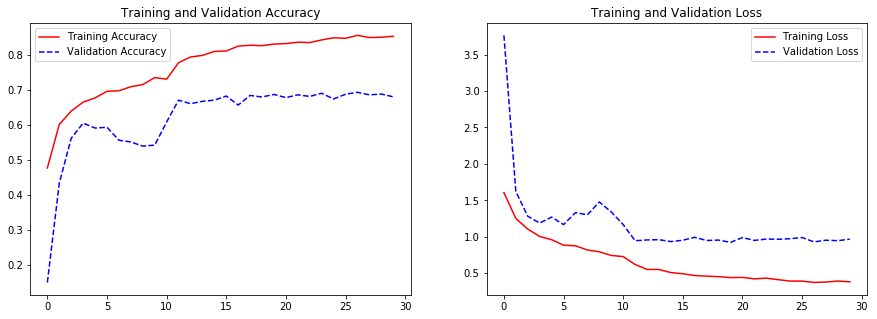

In [11]:
import matplotlib.pyplot as plt

def plot_training(history):
    keys = ['acc', 'val_acc', 'loss', 'val_loss']
    acc, val_acc, loss, val_loss = (history.history[key] for key in keys)
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')

    plt.show()

plot_training(history)

In [12]:
result = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", result[1])

450/450 [==============================] - 328s 729ms/step - loss: 0.3356 - acc: 0.8816
Prediction accuracy on train data = 0.8815588


In [13]:
result = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on validation data =", result[1])

112/112 [==============================] - 80s 713ms/step - loss: 0.9410 - acc: 0.6872
Prediction accuracy on validation data = 0.68715084


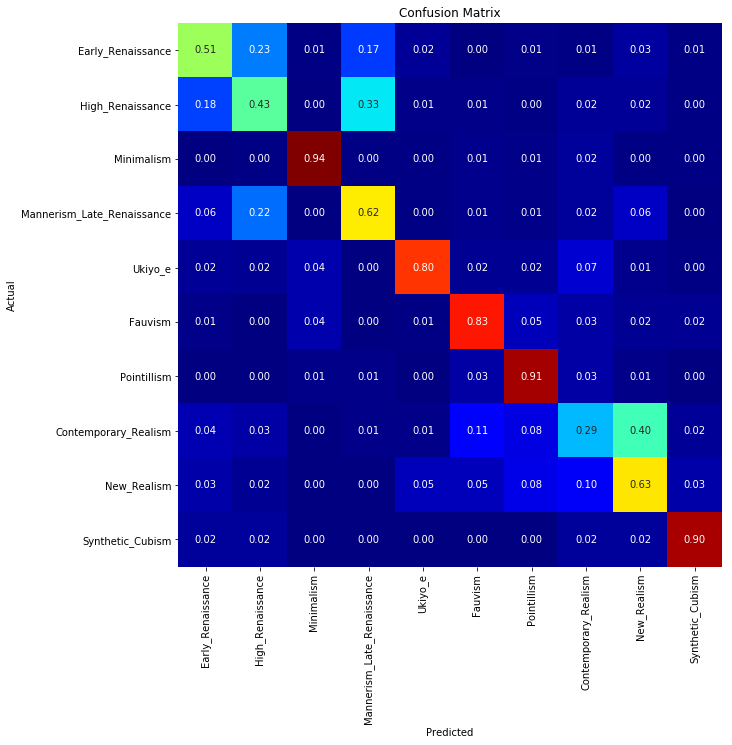

Classification Report:
                            precision    recall  f1-score   support

         Early_Renaissance       0.65      0.51      0.57       274
          High_Renaissance       0.47      0.43      0.45       266
                Minimalism       0.93      0.94      0.93       267
Mannerism_Late_Renaissance       0.53      0.62      0.57       250
                   Ukiyo_e       0.93      0.80      0.86       234
                   Fauvism       0.84      0.83      0.84       186
               Pointillism       0.73      0.91      0.81        99
      Contemporary_Realism       0.35      0.29      0.32        97
               New_Realism       0.33      0.63      0.43        59
          Synthetic_Cubism       0.76      0.90      0.83        42

                  accuracy                           0.67      1774
                 macro avg       0.65      0.69      0.66      1774
              weighted avg       0.68      0.67      0.67      1774



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

label = style_name.tolist()

def show_conf_matrix(model, valid_generator, step_size_valid):
    y_pred, y_true = [], []
    
    for _ in range(step_size_valid):
        X, y = next(valid_generator)
        y_pred.extend(model.predict(X))
        y_true.extend(y)
    
    y_true = np.argmax(np.array(y_true), axis=1)
    y_pred = np.argmax(np.array(y_pred), axis=1)
    
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(class_num))
    conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=label, yticklabels=label, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(class_num), target_names=label))

show_conf_matrix(model, valid_generator, val_step)


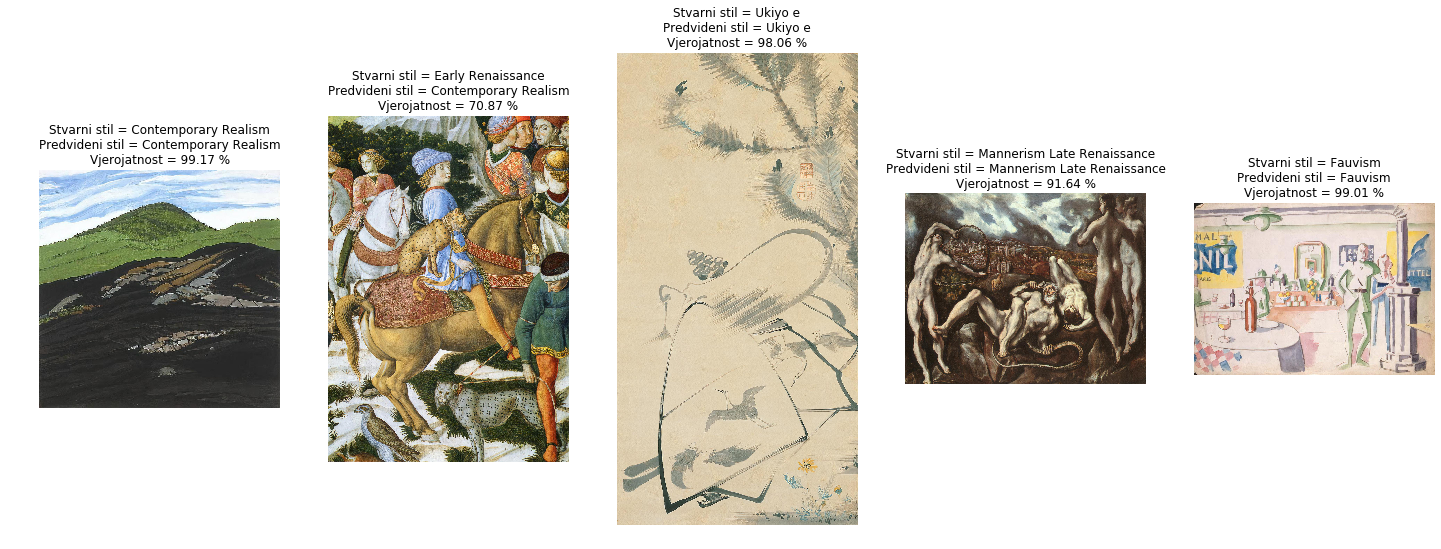

In [19]:
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25, 10))

labels = {v: k for k, v in train_generator.class_indices.items()}

for ax in axes:
    random_artist = random.choice(style_name)
    random_image = random.choice(os.listdir(os.path.join('/kaggle/input/wikiart', random_artist)))
    random_image_file = os.path.join('/kaggle/input/wikiart', random_artist, random_image)

    test_image = image.load_img(random_image_file, target_size=(224, 224))
    test_image = image.img_to_array(test_image) / 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction) * 100
    prediction_idx = np.argmax(prediction)

    title = (f"Stvarni stil = {random_artist.replace('_', ' ')}\n"
             f"Predvideni stil = {labels[prediction_idx].replace('_', ' ')}\n"
             f"Vjerojatnost = {prediction_probability:.2f} %")

    ax.imshow(plt.imread(random_image_file))
    ax.set_title(title)
    ax.axis('off')

plt.show()
